# Q-Learning para Resolução de Labirintos

Este notebook implementa um algoritmo de aprendizado por reforço (Q-Learning) para resolver labirintos. O código é capaz de:

1. Treinar um agente em múltiplos labirintos pequenos (20x20)
2. Testar o agente em labirintos não vistos durante o treinamento
3. Coletar métricas de desempenho para comparação com outros algoritmos (DFS, BFS, A*)
4. Salvar e carregar Q-tables treinadas para uso futuro

## Como usar este notebook

1. **Treinamento**: Execute as células para treinar o agente nos labirintos pequenos
2. **Teste**: Teste o agente em labirintos nunca vistos
3. **Análise**: Analise as métricas coletadas e compare com outros algoritmos

Os resultados são salvos em arquivos CSV para análise comparativa posterior.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import csv
import tracemalloc
from collections import deque
import glob

# Define as ações: Cima, Baixo, Esquerda, Direita
# 6
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
q_table_name = "q_tables/q_table_alpha03_gamma09_eps01_ep1000.pkl"
csv_name = "resultados/q_learning/q_learning_alpha03_gamma09_eps01_ep1000.csv"
learning_rate = 0.3
discount_factor = 0.9
epsilon = 0.1  # Taxa de exploração
num_episodes = 1000

## Classe para Representação do Labirinto

Esta classe encapsula a lógica do labirinto, incluindo sua representação e visualização básica.

In [ ]:
class Maze:
    def __init__(self, maze_array):
        self.maze = maze_array
        self.maze_height, self.maze_width = maze_array.shape
        # Nos arquivos, a entrada está em (0, 1) e a saída em (largura-1, altura-2)
        self.start_position = (0, 1)
        self.goal_position = (self.maze_width - 1, self.maze_height - 2)

    def show_maze(self, path=None):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=10)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=10)

        if path:
            for position in path:
                plt.text(position[0], position[1], "#", ha='center', va='center', color='blue', fontsize=8)

        plt.xticks([]), plt.yticks([])
        plt.show()

## Implementação do Agente Q-Learning

O agente Q-Learning aprende a política ótima por meio de interações com o ambiente (labirinto). Pontos importantes:

- Utiliza uma Q-table para armazenar os valores de cada par estado-ação
- Implementa a política epsilon-greedy para balancear exploração vs. explotação
- Taxa de exploração decai ao longo do tempo (de `exploration_start` até `exploration_end`)
- Atualiza a Q-table usando a equação de Bellman com os parâmetros de taxa de aprendizado e fator de desconto

In [ ]:
class QLearningAgent:
    def __init__(self, state_shape, num_actions=4, learning_rate=0.1, discount_factor=0.9,
                 exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        # Usamos um dicionário para armazenar a Q-table, pois precisamos de uma tabela separada para cada tamanho de labirinto
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes
        self.num_actions = num_actions
        self.training_time_ms = 0
        self.training_episodes = 0
        self.total_updates = 0

    def init_q_table(self, height, width):
        key = f"{height}x{width}"
        if key not in self.q_table:
            self.q_table[key] = np.zeros((height, width, self.num_actions))

    def get_exploration_rate(self, current_episode):
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, maze, current_episode):
        height, width = maze.maze_height, maze.maze_width
        key = f"{height}x{width}"

        # Inicializa a Q-table para este tamanho de labirinto se necessário
        self.init_q_table(height, width)

        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[key][state])

    def update_q_table(self, state, action, next_state, reward, maze):
        height, width = maze.maze_height, maze.maze_width
        key = f"{height}x{width}"

        # Inicializa a Q-table para este tamanho de labirinto se necessário
        self.init_q_table(height, width)

        best_next_action = np.argmax(self.q_table[key][next_state])
        current_q_value = self.q_table[key][state][action]
        new_q_value = current_q_value + self.learning_rate * (
            reward + self.discount_factor * self.q_table[key][next_state][best_next_action] - current_q_value
        )
        self.q_table[key][state][action] = new_q_value


## Funções para Salvar e Carregar Q-Table

Estas funções permitem salvar a Q-table treinada em um arquivo para uso futuro, evitando a necessidade de retreinar o agente cada vez que precisar testá-lo em novos labirintos.

In [ ]:
import pickle

def salvar_q_table(agente, caminho_arquivo):
    """
    Salva a Q-table do agente em um arquivo usando pickle.

    Args:
        agente: O objeto QLearningAgent com a Q-table treinada
        caminho_arquivo: Caminho onde a Q-table será salva
    """
    # Criar diretório se não existir
    os.makedirs(os.path.dirname(caminho_arquivo), exist_ok=True)

    # Dados a serem salvos (Q-table e parâmetros do agente)
    dados = {
        'q_table': agente.q_table,
        'learning_rate': agente.learning_rate,
        'discount_factor': agente.discount_factor,
        'exploration_start': agente.exploration_start,
        'exploration_end': agente.exploration_end,
        'num_episodes': agente.num_episodes,
        'training_time_ms': agente.training_time_ms,
        'training_episodes': agente.training_episodes,
        'total_updates': agente.total_updates
    }

    # Salvar usando pickle
    with open(caminho_arquivo, 'wb') as arquivo:
        pickle.dump(dados, arquivo)

    print(f"✅ Q-table salva em: {caminho_arquivo}")

def carregar_q_table(caminho_arquivo):
    """
    Carrega uma Q-table salva e cria um novo agente com os parâmetros salvos.

    Args:
        caminho_arquivo: Caminho do arquivo com a Q-table salva

    Returns:
        Um objeto QLearningAgent com a Q-table carregada
    """
    # Verificar se o arquivo existe
    if not os.path.exists(caminho_arquivo):
        raise FileNotFoundError(f"Arquivo não encontrado: {caminho_arquivo}")

    # Carregar os dados
    with open(caminho_arquivo, 'rb') as arquivo:
        dados = pickle.load(arquivo)

    # Criar um novo agente
    agente = QLearningAgent(
        state_shape=None,  # Não importa, será substituído
        learning_rate=dados['learning_rate'],
        discount_factor=dados['discount_factor'],
        exploration_start=dados['exploration_start'],
        exploration_end=dados['exploration_end'],
        num_episodes=dados['num_episodes']
    )

    # Substituir a Q-table e outros parâmetros
    agente.q_table = dados['q_table']
    agente.training_time_ms = dados['training_time_ms']
    agente.training_episodes = dados['training_episodes']
    agente.total_updates = dados['total_updates']

    print(f"✅ Q-table carregada de: {caminho_arquivo}")
    return agente

## Execução de um Episódio

Esta função executa um episódio completo do agente no labirinto, interagindo com o ambiente até alcançar o objetivo ou atingir o limite de passos.

Os parâmetros de recompensa são:
- `goal_reward`: Recompensa por atingir o objetivo (valor positivo)
- `wall_penalty`: Penalidade por bater em uma parede (valor negativo)
- `step_penalty`: Penalidade por cada passo dado (valor negativo pequeno)

A função retorna métricas como tempo de execução, memória utilizada, comprimento do caminho e nós visitados.

In [ ]:
def finish_episode(agent, maze, current_episode, train=True, goal_reward=100, wall_penalty=-10, step_penalty=-1):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    nos_visitados = set()
    nos_visitados.add(current_state)

    # Iniciar medição de memória e tempo
    tracemalloc.start()
    tempo_inicio = time.perf_counter()

    while not is_done:
        action = agent.get_action(current_state, maze, current_episode)
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Verifica se está fora dos limites ou bateu na parede
        if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
            next_state[1] < 0 or next_state[1] >= maze.maze_height or
            maze.maze[next_state[1]][next_state[0]] == 0):  # 0 é parede nos .npy
            reward = wall_penalty
            next_state = current_state
        # Verifica se chegou ao objetivo
        elif next_state == maze.goal_position:
            path.append(next_state)
            nos_visitados.add(next_state)
            reward = goal_reward
            is_done = True
        # Deu mais um passo, mas não chegou ao objetivo
        else:
            path.append(next_state)
            nos_visitados.add(next_state)
            reward = step_penalty

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action, next_state, reward, maze)

        current_state = next_state

        # Limite de passos para evitar loops infinitos
        if episode_step > 10000:
            is_done = True

    # Finalizar medição de memória e tempo
    tempo_fim = time.perf_counter()
    memoria_usada = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    return {
        "caminho": path,
        "nos_visitados": list(nos_visitados),
        "tempo_ms": (tempo_fim - tempo_inicio) * 1000,
        "memoria_bytes": memoria_usada,
        "comprimento": len(path) if path[-1] == maze.goal_position else 0,
        "qtd_nos_visitados": len(nos_visitados),
        "encontrou_caminho": path[-1] == maze.goal_position
    }

## Treinamento em Múltiplos Labirintos

Esta função treina o agente em vários labirintos, distribuindo os episódios entre eles. Ela também registra métricas de treinamento como tempo total e número de atualizações da Q-table.

In [ ]:
def treinar_agente_multi_labirintos(agente, labirintos, num_episodios=100):
    """Treina o agente em múltiplos labirintos"""
    print(f"Treinando agente em {len(labirintos)} labirintos...")
    tempo_inicio_treino = time.perf_counter()

    # Ajustar o número de episódios para garantir treinamento uniforme em todos os labirintos
    episodios_por_labirinto = num_episodios // len(labirintos)
    agente.training_episodes = episodios_por_labirinto * len(labirintos)

    total_updates = 0
    for idx, labirinto in enumerate(labirintos):
        print(f"Treinando no labirinto {idx+1}/{len(labirintos)}")
        for episodio in range(episodios_por_labirinto):
            # Treinar no episódio atual
            resultado = finish_episode(agente, labirinto, episodio, train=True)
            # Contar atualizações da Q-table (aproximadamente)
            total_updates += len(resultado["caminho"])

    # Finalizar contagem de tempo
    tempo_fim_treino = time.perf_counter()
    agente.training_time_ms = (tempo_fim_treino - tempo_inicio_treino) * 1000
    agente.total_updates = total_updates

    print(f"Treinamento concluído em {agente.training_time_ms/1000:.2f} segundos!")
    print(f"Total de episódios: {agente.training_episodes}")
    print(f"Total de atualizações da Q-table: {agente.total_updates}")

## Carregamento de Labirintos

Esta função carrega todos os labirintos de um diretório especificado.

In [ ]:
def carregar_labirintos(diretorio):
    """Carrega todos os labirintos de um diretório"""
    labirintos = []
    arquivos = sorted(glob.glob(os.path.join(diretorio, "*.npy")))

    for arquivo in arquivos:
        labirinto_array = np.load(arquivo)
        labirintos.append(Maze(labirinto_array))

    return labirintos

## Criação e Treinamento do Agente

Esta célula cria o agente Q-Learning com os parâmetros definidos e inicia o treinamento nos labirintos pequenos.

**Parâmetros para ajuste:**
- `learning_rate`: Taxa de aprendizado (quanto maior, mais rápido aprende, mas pode ficar instável)
- `discount_factor`: Fator de desconto (quanto maior, mais valoriza recompensas futuras)
- `exploration_start`: Taxa de exploração inicial (probabilidade de escolher ações aleatórias no início)
- `exploration_end`: Taxa de exploração final (probabilidade mínima de exploração)
- `num_episodes`: Número total de episódios de treinamento

In [ ]:
diretorio_treino = "labirintos/pequenos"
labirintos_treino = carregar_labirintos(diretorio_treino)

# Criar o agente
agente = QLearningAgent(
    state_shape=(21, 21),  # Tamanho do estado para labirintos 20x20 (com bordas)
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    exploration_start=1.0,
    exploration_end=epsilon,
    num_episodes=num_episodes  # Total de episódios de treinamento
)

# Treinar o agente nos labirintos de treinamento
treinar_agente_multi_labirintos(agente, labirintos_treino, num_episodios=num_episodes)


Treinando agente em 20 labirintos...
Treinando no labirinto 1/20
Treinando no labirinto 2/20
Treinando no labirinto 3/20
Treinando no labirinto 4/20
Treinando no labirinto 5/20
Treinando no labirinto 6/20
Treinando no labirinto 7/20
Treinando no labirinto 8/20
Treinando no labirinto 9/20
Treinando no labirinto 10/20
Treinando no labirinto 11/20
Treinando no labirinto 12/20
Treinando no labirinto 13/20
Treinando no labirinto 14/20
Treinando no labirinto 15/20
Treinando no labirinto 16/20
Treinando no labirinto 17/20
Treinando no labirinto 18/20
Treinando no labirinto 19/20
Treinando no labirinto 20/20
Treinamento concluído em 990.44 segundos!
Total de episódios: 1000
Total de atualizações da Q-table: 1881803


## Visualização do Labirinto e Caminho

Estas funções permitem visualizar o labirinto, o caminho encontrado pelo agente e os nós visitados durante a exploração.

- As paredes são representadas em azul escuro
- O espaço livre é representado em azul claro
- O caminho encontrado é representado em amarelo
- Os nós visitados são representados em verde

In [ ]:
import matplotlib.patches as mpatches

def get_dynamic_figsize(width_data, height_data, min_inches=8, max_inches=20):
    """
    Calcula o tamanho da figura dinamicamente com base nas dimensões dos dados.
    """
    dpi = plt.rcParams.get('figure.dpi', 100.0)

    ideal_w_inches = width_data / dpi
    ideal_h_inches = height_data / dpi

    final_w_inches = max(min_inches, min(max_inches, ideal_w_inches))
    final_h_inches = max(min_inches, min(max_inches, ideal_h_inches))

    if (ideal_w_inches > max_inches or ideal_h_inches > max_inches) and not (ideal_w_inches > max_inches and ideal_h_inches > max_inches):
        if ideal_w_inches > ideal_h_inches:
            ratio = height_data / width_data
            final_h_inches = final_w_inches * ratio
        elif ideal_h_inches > ideal_w_inches:
            ratio = width_data / height_data
            final_w_inches = final_h_inches * ratio

        final_w_inches = max(min_inches, final_w_inches)
        final_h_inches = max(min_inches, final_h_inches)

    elif ideal_w_inches < min_inches and ideal_h_inches < min_inches and ideal_w_inches != ideal_h_inches:
        if ideal_w_inches > ideal_h_inches:
            ratio = ideal_h_inches / ideal_w_inches
            final_h_inches = final_w_inches * ratio
        else:
            ratio = ideal_w_inches / ideal_h_inches
            final_w_inches = final_h_inches * ratio

    return (final_w_inches, final_h_inches)

def visualizar_caminho_qlearning(maze, caminho, nos_visitados):
    """
    Visualiza o labirinto com o caminho encontrado e nós visitados pelo Q-Learning.
    Similar à visualização usada no DFS/BFS.
    """
    # Criar uma matriz para visualização
    visualizacao = np.array(maze.maze.copy(), dtype=int)

    # Marcar nós visitados com valor 3
    for x, y in nos_visitados:
        if visualizacao[y][x] == 1:  # Só marca se for um espaço vazio
            visualizacao[y][x] = 3

    # Marcar caminho encontrado com valor 2
    if caminho and caminho[-1] == maze.goal_position:
        for x, y in caminho:
            visualizacao[y][x] = 2

    # Tamanho dinâmico da figura
    figsize = get_dynamic_figsize(maze.maze_width, maze.maze_height)
    plt.figure(figsize=figsize)

    # Mostrar o labirinto com os caminhos
    plt.imshow(visualizacao, cmap='viridis', vmin=0, vmax=3, interpolation='nearest')
    plt.axis('off')
    plt.title("Caminho e Nós Visitados (Q-Learning)")

    # Adicionar legenda
    legenda = [
        mpatches.Patch(color=plt.colormaps['viridis'](0/3), label='Parede (0)'),
        mpatches.Patch(color=plt.colormaps['viridis'](1/3), label='Espaço livre (1)'),
        mpatches.Patch(color=plt.colormaps['viridis'](2/3), label='Caminho final (2)'),
        mpatches.Patch(color=plt.colormaps['viridis'](3/3), label='Nós visitados (3)')
    ]
    plt.legend(handles=legenda, loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Mostrar a visualização
    plt.show()

    # Informações adicionais sobre o resultado
    encontrou_caminho = caminho and caminho[-1] == maze.goal_position
    print(f"Caminho encontrado: {encontrou_caminho}")
    if encontrou_caminho:
        print(f"Comprimento do caminho: {len(caminho)}")
    print(f"Número de nós visitados: {len(nos_visitados)}")

## Teste do Agente e Coleta de Métricas

Esta função testa o agente em um conjunto de labirintos e coleta métricas para análise. As métricas são salvas em um arquivo CSV.

Métricas coletadas:
1. **Métricas gerais**:
   - Tempo de execução (ms)
   - Número de nós visitados
   - Se o caminho foi encontrado
   - Comprimento do caminho
   - Memória utilizada (KB)

2. **Métricas específicas de Q-Learning**:
   - Tempo de treinamento (ms)
   - Número de episódios de treinamento
   - Taxa de aprendizado
   - Fator de desconto
   - Taxas de exploração (inicial e final)
   - Total de atualizações da Q-table

In [ ]:
def testar_agente_e_coletar_dados(agente, labirintos, nome_arquivo):
    """Testa o agente em um conjunto de labirintos e coleta métricas"""
    resultados = []

    print(f"Testando agente em {len(labirintos)} labirintos...")
    for idx, labirinto in enumerate(labirintos):
        print(f"Testando no labirinto {idx+1}/{len(labirintos)}")

        # Testar o agente
        resultado = finish_episode(agente, labirinto, 0, train=False)

        # Visualizar o labirinto com o caminho encontrado e nós visitados
        visualizar_caminho_qlearning(labirinto, resultado["caminho"], resultado["nos_visitados"])

        # Registrar os resultados
        resultados.append([
            "Q-Learning",
            "pequeno",
            idx + 1,
            round(resultado["tempo_ms"], 2),
            resultado["qtd_nos_visitados"],
            resultado["encontrou_caminho"],
            resultado["comprimento"],
            round(resultado["memoria_bytes"] / 1024, 2),  # em KB
            # Métricas específicas de Q-Learning
            round(agente.training_time_ms, 2),  # tempo de treinamento em ms
            agente.training_episodes,  # número total de episódios de treinamento
            agente.learning_rate,  # taxa de aprendizado
            agente.discount_factor,  # fator de desconto
            agente.exploration_start,  # taxa de exploração inicial
            agente.exploration_end,  # taxa de exploração final
            agente.total_updates  # número total de atualizações da Q-table
        ])

    # Salvar os resultados em um arquivo CSV
    os.makedirs(os.path.dirname(nome_arquivo), exist_ok=True)
    with open(nome_arquivo, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "algoritmo", "tamanho_labirinto", "indice_labirinto",
            "tempo_execucao_ms", "nos_visitados", "encontrou_caminho",
            "comprimento_caminho", "memoria_kb",
            # Cabeçalhos para métricas específicas de Q-Learning
            "tempo_treinamento_ms", "episodios_treinamento",
            "taxa_aprendizado", "fator_desconto",
            "exploracao_inicial", "exploracao_final",
            "total_atualizacoes"
        ])
        writer.writerows(resultados)

    print(f"✅ Resultados salvos em: {nome_arquivo}")
    return resultados

## Salvamento da Q-Table

Esta célula salva a Q-table treinada para uso futuro. O nome do arquivo incorpora os parâmetros usados no treinamento.

In [ ]:
# Salvar a Q-table treinada
salvar_q_table(agente, q_table_name)

✅ Q-table salva em: q_learning/q_table_alpha03_gamma09_eps01_ep1000.pkl


## Teste em Novos Labirintos

Esta célula carrega os labirintos de teste (que o agente nunca viu durante o treinamento) e testa o desempenho do agente neles.

**Observação**: Usar o diretório `labirintos/teste_qlearning` que está no Drive.

Testando agente em 20 labirintos...
Testando no labirinto 1/20


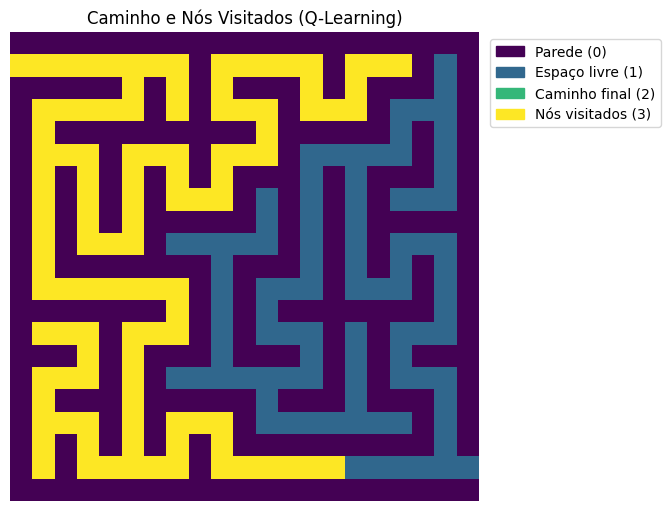

Caminho encontrado: False
Número de nós visitados: 109
Testando no labirinto 2/20


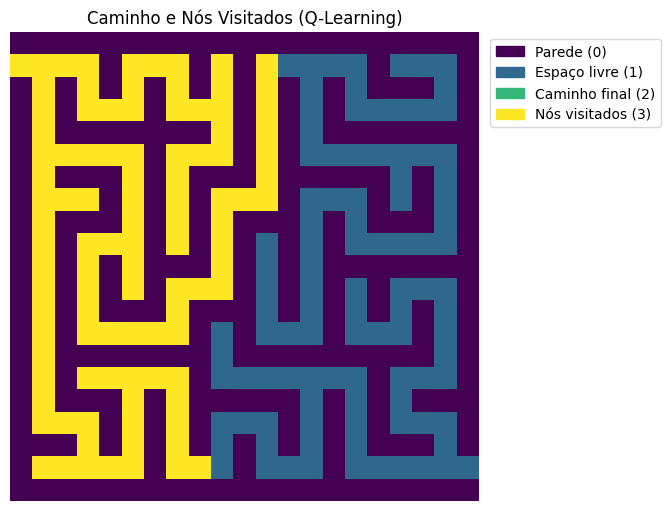

Caminho encontrado: False
Número de nós visitados: 101
Testando no labirinto 3/20


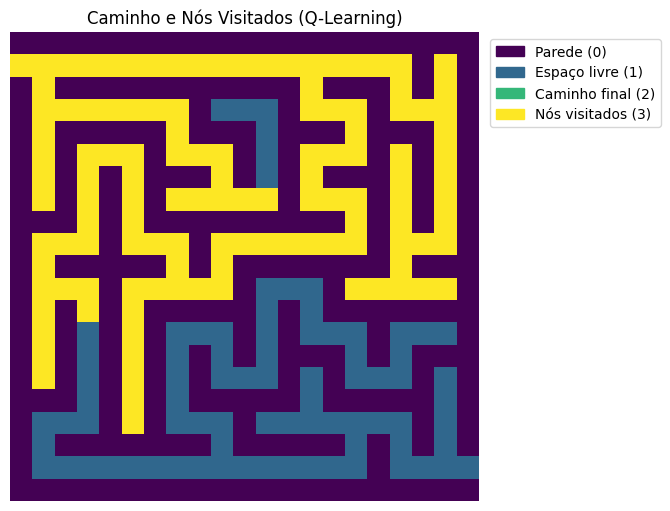

Caminho encontrado: False
Número de nós visitados: 121
Testando no labirinto 4/20


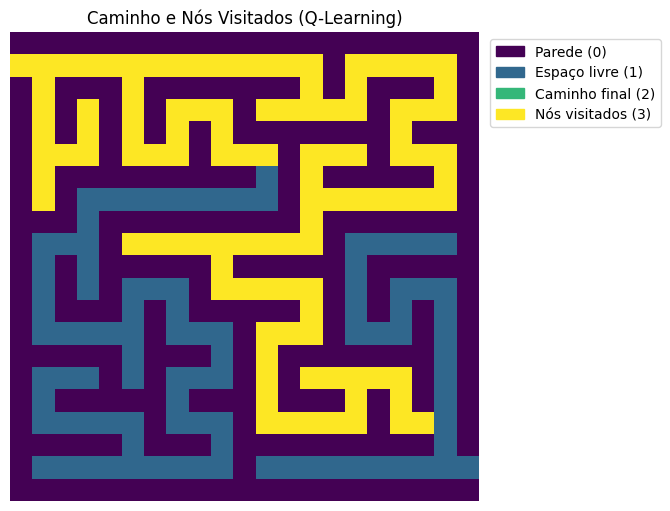

Caminho encontrado: False
Número de nós visitados: 107
Testando no labirinto 5/20


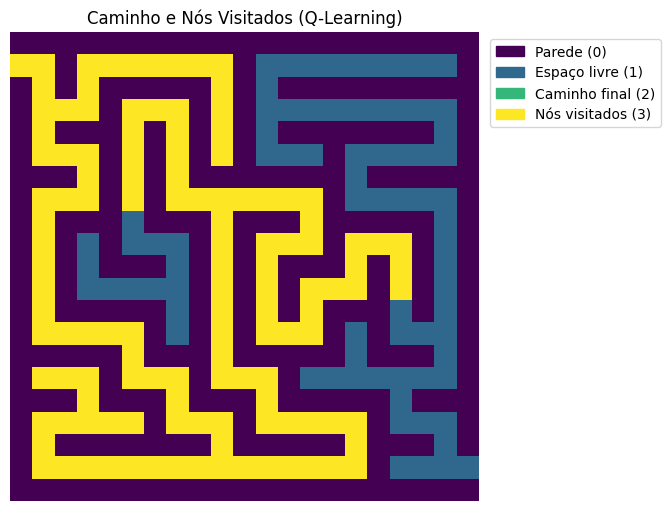

Caminho encontrado: False
Número de nós visitados: 124
Testando no labirinto 6/20


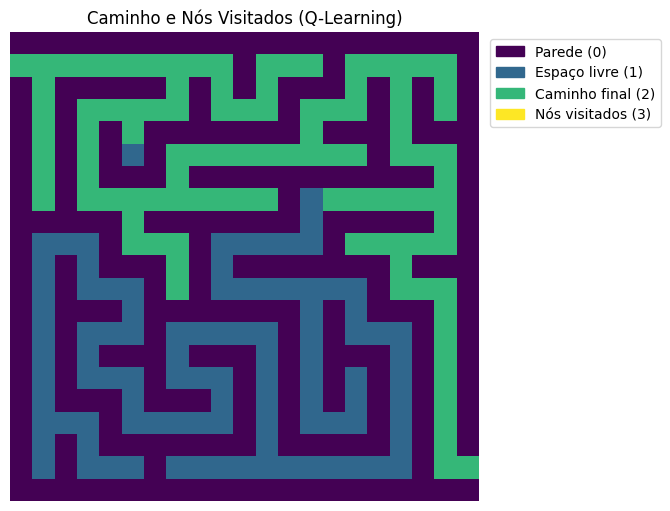

Caminho encontrado: True
Comprimento do caminho: 3243
Número de nós visitados: 103
Testando no labirinto 7/20


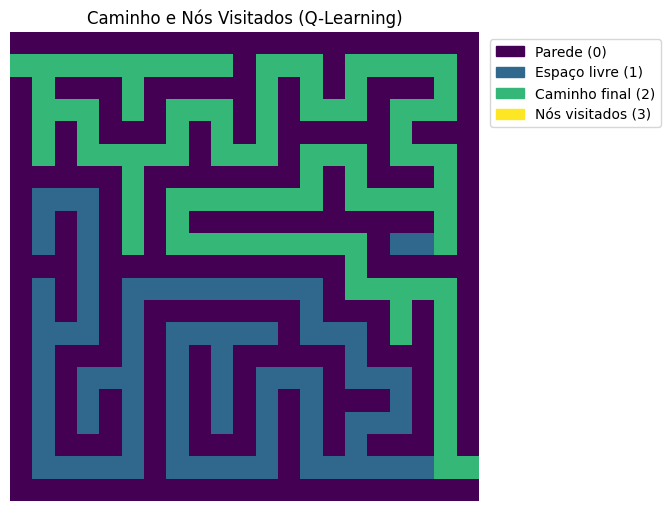

Caminho encontrado: True
Comprimento do caminho: 3673
Número de nós visitados: 107
Testando no labirinto 8/20


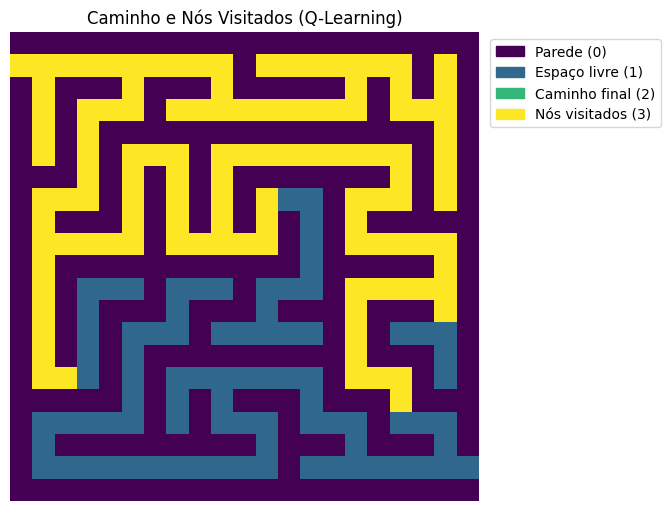

Caminho encontrado: False
Número de nós visitados: 117
Testando no labirinto 9/20


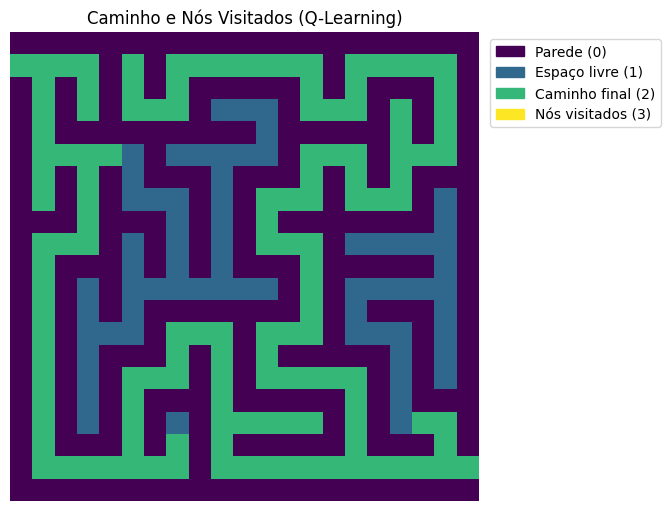

Caminho encontrado: True
Comprimento do caminho: 3965
Número de nós visitados: 134
Testando no labirinto 10/20


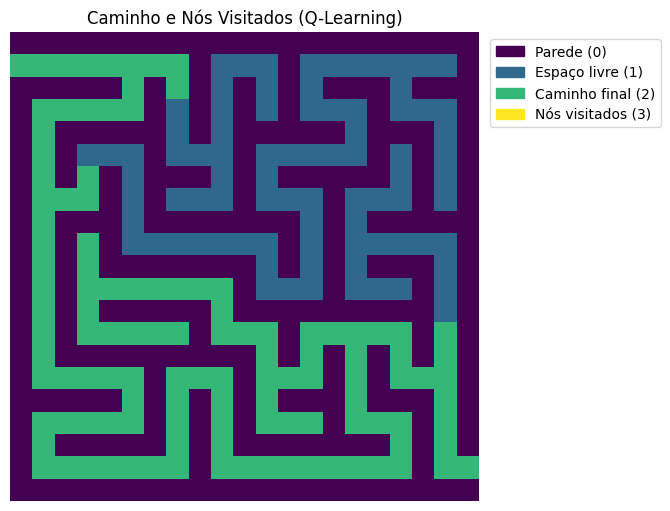

Caminho encontrado: True
Comprimento do caminho: 3823
Número de nós visitados: 117
Testando no labirinto 11/20


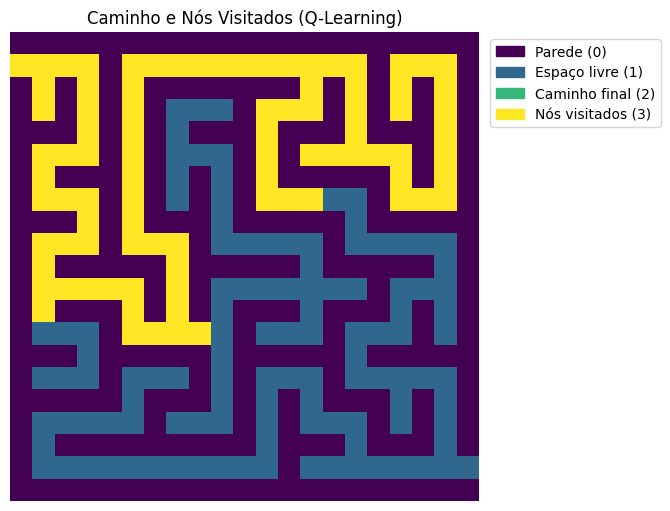

Caminho encontrado: False
Número de nós visitados: 88
Testando no labirinto 12/20


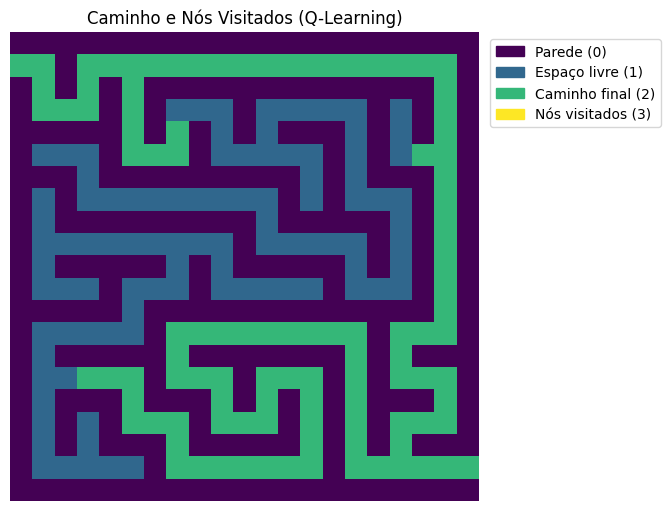

Caminho encontrado: True
Comprimento do caminho: 2285
Número de nós visitados: 105
Testando no labirinto 13/20


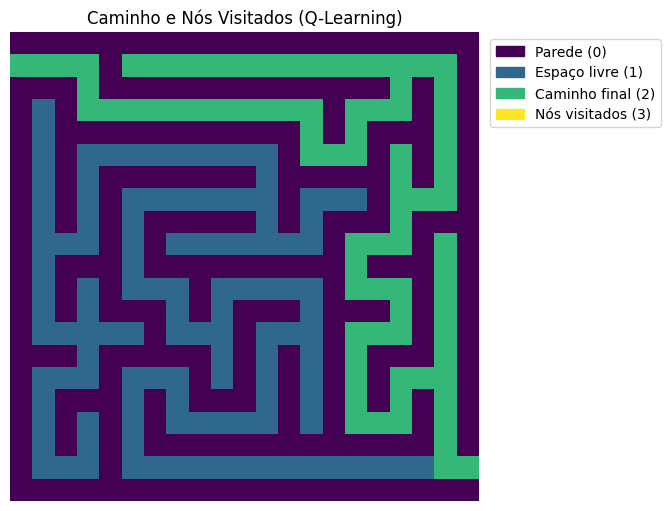

Caminho encontrado: True
Comprimento do caminho: 4241
Número de nós visitados: 83
Testando no labirinto 14/20


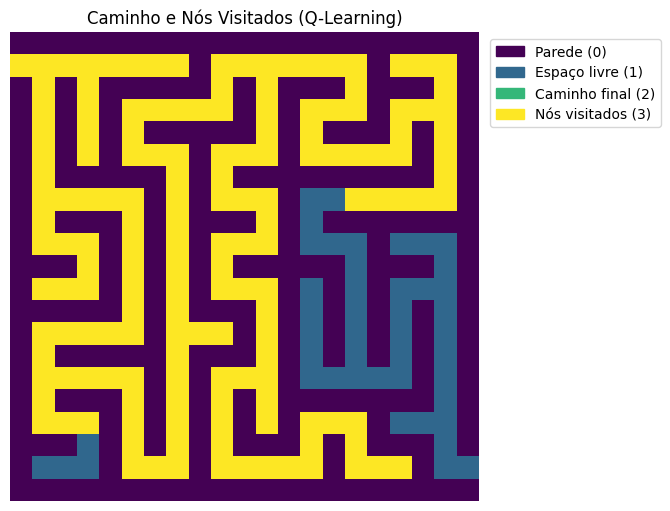

Caminho encontrado: False
Número de nós visitados: 156
Testando no labirinto 15/20


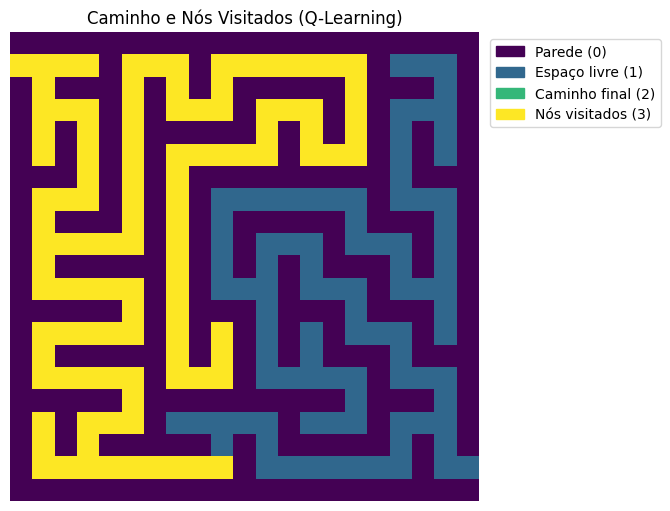

Caminho encontrado: False
Número de nós visitados: 108
Testando no labirinto 16/20


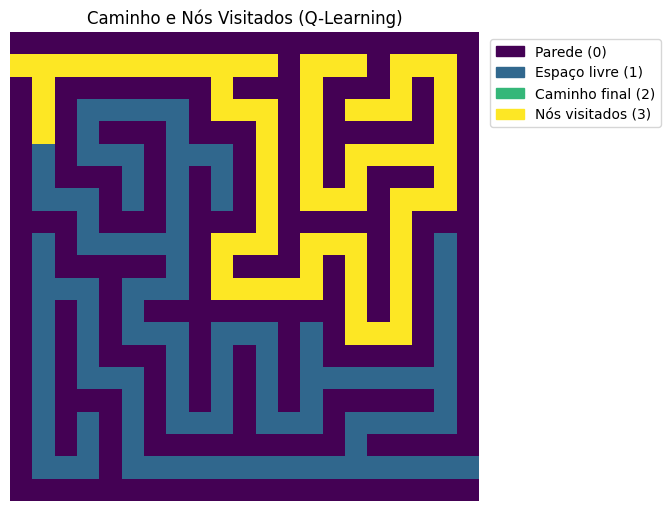

Caminho encontrado: False
Número de nós visitados: 79
Testando no labirinto 17/20


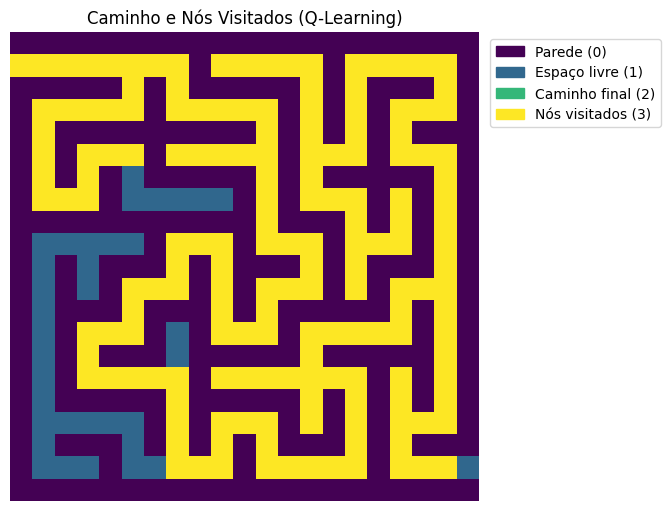

Caminho encontrado: False
Número de nós visitados: 166
Testando no labirinto 18/20


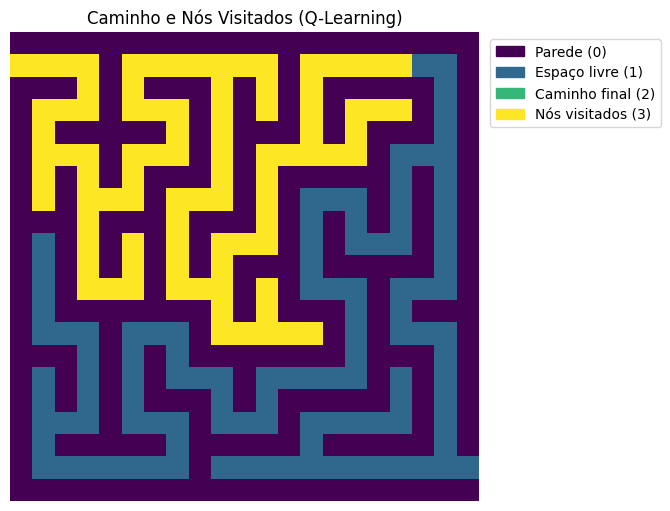

Caminho encontrado: False
Número de nós visitados: 90
Testando no labirinto 19/20


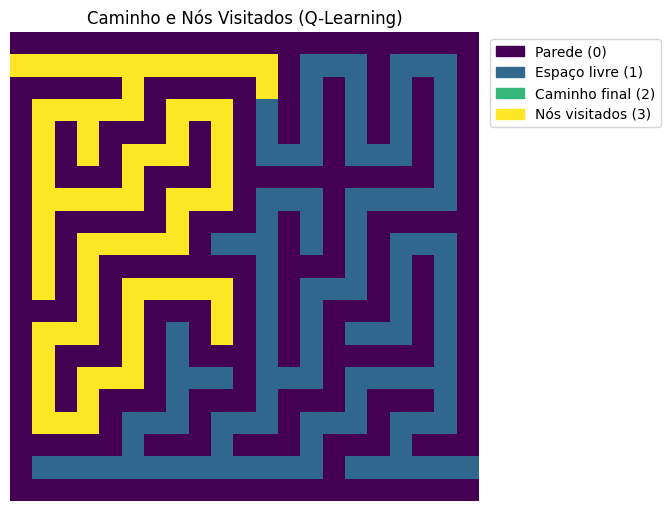

Caminho encontrado: False
Número de nós visitados: 79
Testando no labirinto 20/20


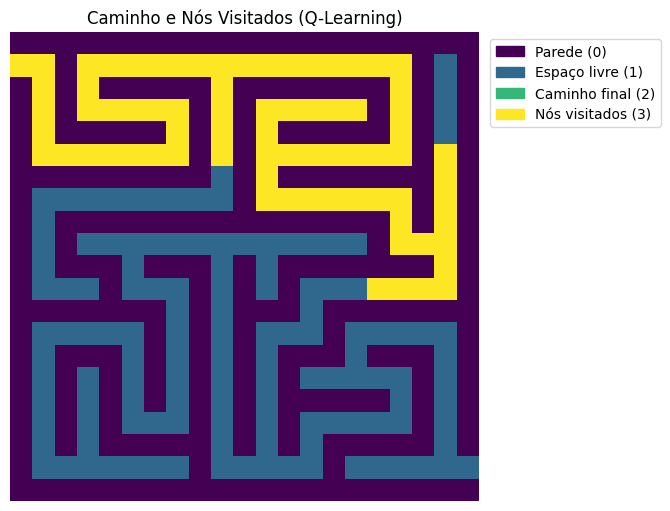

Caminho encontrado: False
Número de nós visitados: 75
✅ Resultados salvos em: resultados/q_learning/q_learning_alpha03_gamma09_eps01_ep1000.csv

Agente treinado e testado nos labirintos de treinamento.


In [ ]:
# Carregar labirintos de teste (que o agente nunca viu)
diretorio_teste = "labirintos/teste_qlearning"  # Substitua pelo caminho correto
labirintos_teste = carregar_labirintos(diretorio_teste)

# Testar o agente nos labirintos de teste
resultados_teste = testar_agente_e_coletar_dados(
    agente, labirintos_teste, csv_name
)

print("\nAgente treinado e testado nos labirintos de treinamento.")